## 准备工作

In [66]:
import scipy.io as sio  # 从.mat文件中读取数据集
import numpy as np
from tqdm import tqdm
from differential_evolution.DifferentialEvolution import DifferentialEvolution
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVC用于分类，SVR用于回归
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### 实值映射到0-1

In [67]:
# 根据种群个体的编码值，获得要选择的实例的索引
def get_indices(x):
    x = x.astype(int)  # 数据范围在0-2之间，转化成int的同时会舍去小数部分，从而将个体映射到0-1编码
    indices = np.where(x == 1)  # 1代表选择该实例，返回值是tuple，tuple[0]取元组中的第一个元素
    return indices[0]


# 得到分类、以及分类所对应的索引
def get_class_index(y):
    # 统计每个类别的个数，y.max()+1是类别的个数
    num_class = y.max() + 1
    counts = np.zeros(num_class, dtype=int)
    classes = []
    for i in range(y.shape[0]):  # y.shape[0]相当于y的长度
        counts[y[i]] += 1
    for i in range(num_class):
        classes.append(
            np.where(y == i)[0])  # np.where() 返回值是一个tuple数组，np.where(y == i)[0],表示取出该tuple数组的第一个元素，是一个ndarray数组
    return num_class, classes, counts

### 获取实例子集

In [68]:
# 根据索引得到要选择的子集：数据和标签
# minimum的最大值不能超过数据集中包含的所有类别的最小数量
def get_sub_dataset(xi, indices, x, y, num_class, classes, minimum):
    # 根据索引得到实例子集
    lenth = len(indices)
    x_sub = x[indices, :]
    y_sub = y[indices]

    #print("实例子集x：", x_sub)
    #print("实例子集y：", y_sub)
    # 计算实例子集各个类别的数量
    counts_sub = np.zeros(num_class, dtype=int)
    for i in range(y_sub.shape[0]):
        counts_sub[y_sub[i]] += 1
    #print("实例子集的数量：", counts_sub)
    # 遍历子集中各个类别的数量，保证大于最小数量
    for i in range(num_class):
        # 当实例个数小于minimum，随机添加实例达到最小限制
        if counts_sub[i] < minimum:
            # 转换成集合进行差运算（& | -，分别是交、并、差） unselected_indices是一个set集合
            unselected_indices_set = set(classes[i]) - set(indices)
            # list(unselected_indices)将集合转换成list
            unselected_indices = np.array(list(unselected_indices_set))
            # replace=False表示不允许重复
            random_selecte_indices = np.random.choice(unselected_indices, size=minimum - counts_sub[i], replace=False)

            # 添加后更改个体xi的参数
            for j in range(0, minimum - counts_sub[i]):  # 小于minimum时，添加实例时，需要同步更改xi个体的实值大小，由0-1的改为1-2
                xi[random_selecte_indices[j]] = np.random.rand() + 1  # np.random.rand()生成0-1的随机数
                index = np.searchsorted(indices, random_selecte_indices[j])
                indices = np.insert(indices, index, random_selecte_indices[j])
                x_sub = np.insert(x_sub, index, x[random_selecte_indices[j], :], axis=0)
                y_sub = np.insert(y_sub, index, y[random_selecte_indices[j]])

            #print(f"类别{i}所要补充的个体数为{minimum - counts_sub[i]},索引为：", random_selecte_indices)
            #random_selecte_x = x[random_selecte_indices, :]
            #random_selecte_y = y[random_selecte_indices]
            # 注意以下是将添加的实例拼接到原来实例子集的后面，这个和新的个体xi并非一一对应，因为模型训练时，划分数据集，会把实例顺序打乱，（若想保持一致，后面可以再进行优化）
            #x_sub = np.concatenate((x_sub, random_selecte_x))  # 将子集拼接在一起 concatenate默认axis=0
            #y_sub = np.concatenate((y_sub, random_selecte_y))  # 将子集拼接在一起 concatenate默认axis=0
    #print("最终的索引为：", indices)
    return x_sub, y_sub, xi

### 适应度函数

In [69]:
# 适应度函数/目标函数
def objective_function(xi, dataset_x, dataset_y, model, minimum):
    # 先将x的实值编码四舍五入得到0-1编码，根据编码得到训练子集
    indices = get_indices(xi)
    num_class, classes, counts = get_class_index(dataset_y)
    x_sub, y_sub, xi = get_sub_dataset(xi, indices, dataset_x, dataset_y, num_class, classes, minimum=minimum)

    # 模型训练
    x_train, x_test, y_train, y_test = train_test_split(x_sub, y_sub, test_size=0.3, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)

    # 计算错误率
    error_rate = 1 - accuracy
    return error_rate


# 求适应度
def fitness(x, model, dataset_x, dataset_y, minimum):
    result = np.empty(x.shape[0])  # 记录种群中个体的适应度
    # 计算每个个体的适应度
    for i in range(0, x.shape[0]):
        result[i] = objective_function(x[i, :], dataset_x, dataset_y, model, minimum)
    return result

## 训练阶段

### 加载数据集

In [90]:
# 读取.mat文件
mat_data = sio.loadmat('../data/dataset/German.mat')
#print(mat_data.keys())
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y']
dataset_y = dataset_y[:, 0]
# 显示变量信息
print("x的形状:", dataset_x.shape)
print("y的数据类型:", dataset_y.shape)
# 统计每个类别的个数，y.max()+1是类别的个数
counts = np.zeros(dataset_y.max() + 1)
for i in range(dataset_y.shape[0]):
    counts[dataset_y[i]] += 1
print("每种类别的数量：", counts)

x的形状: (1000, 24)
y的数据类型: (1000,)
每种类别的数量： [700. 300.]


### 参数设定

In [104]:
NP = 50  # 个体数目
D = dataset_y.shape[0]  # 目标函数中变量的个数
G = 100  # 最大迭代数
CR = 0.1  # 交叉算子
Threshold = 1e-6  # 阈值
F = 0.9  # 变异算子
Left = 0  # 左边界
Right = 2  # 右边界

# 初始化 SVM 分类器
# 通过管道将标准化操作和模型相连接
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', cache_size=600))  # 'linear' 是线性核，也可以选择 'rbf', 'poly' 等核函数

In [105]:
x = np.random.rand(NP, D) * (Right - Left) + Left  # 在[Left,Right]之间产生随机数
x_best = np.empty(D)
# 记录进化迭代的过程
number_generations = G
per_generation_optimal_value = np.zeros(G)

x_fitness = fitness(x, clf, dataset_x, dataset_y, minimum=15)

de = DifferentialEvolution(NP, D, G, CR, Threshold, F, Left, Right)

with tqdm(total=G, desc="DE") as pbar:
    for i in range(0, G):
        #v=variation(x,F) # 变异
        v = de.variation_optimize(x)  # 变异的优化
        c = de.cross(x, v)  # 交叉

        c = de.boundary_process(c)  # 若超出边界则重新生成

        c_fitness = fitness(c, clf, dataset_x, dataset_y, minimum=15)  # 对新的试验种群求适应度
        for m in range(0, x.shape[0]):
            if c_fitness[m] < x_fitness[m]:  # 贪婪地选择当前最优个体
                x[m, :] = c[m, :]
                x_fitness[m] = c_fitness[m]
        index = np.argmin(x_fitness)  # 记录最优个体索引
        per_generation_optimal_value[i] = x_fitness[index]  # 记录最优适应度
        x_best = x[index, :]
        # 动态更新进度条信息
        pbar.set_postfix({
            "当前迭代次数": i + 1,
            "最优个体索引": index,
            "目标函数最小值": round(x_fitness[index], 3),
            "当前最高准确率": round(1 - x_fitness[index], 3)
        })
        # 更新进度条
        pbar.update(1)

DE: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s, 当前迭代次数=100, 最优个体索引=34, 目标函数最小值=0.156, 当前最高准确率=0.844]


### 绘图

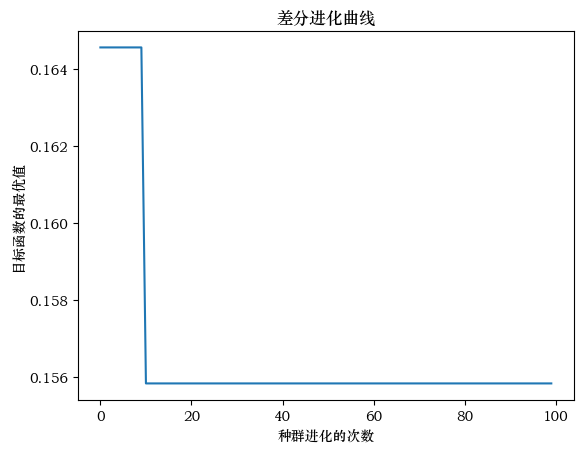

In [106]:
import matplotlib.pyplot as plt

# 设置可显示中文宋体
plt.rcParams['font.family'] = 'STZhongsong'
# 生成 x 轴数据：0 到 G，间隔为 1
x = np.arange(0, number_generations, 1)

# 生成 y 轴数据：每次迭代的最优值
y = per_generation_optimal_value

# 绘制折线图
plt.plot(x, y)

# 设置标题和坐标轴标签
plt.title("差分进化曲线")
plt.xlabel("种群进化的次数")
plt.ylabel("目标函数的最优值")

# 显示图形
plt.show()


## 测试

### 模型测试

In [107]:
num_class, classes, counts = get_class_index(dataset_y)

print("原始数据集分类数：", num_class)
print("原始数据集各分类数量：", counts)

indices = get_indices(x_best)
x_best_sub, y_best_sub, xi = get_sub_dataset(x_best, indices, dataset_x, dataset_y, num_class, classes, minimum=10)

num_class_x_best, classes_x_best, counts_x_best = get_class_index(y_best_sub)

print("最优实例子集对应索引：", indices)
print("最优实例子集各分类数量：", counts_x_best)
# 模型训练
x_train, x_test, y_train, y_test = train_test_split(x_best_sub, y_best_sub, test_size=0.3, random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
# 计算错误率
error_rate = 1 - accuracy
print(f'Error_rate: {accuracy:.2f}')
# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

原始数据集分类数： 2
原始数据集各分类数量： [700 300]
最优实例子集对应索引： [  1   3   5   6   8   9  10  12  13  14  15  16  17  18  23  24  25  30
  31  34  35  37  38  41  43  45  47  52  53  55  56  59  61  63  64  65
  66  68  70  77  79  83  85  87  88  89  91  93  95  96  97 100 101 102
 105 106 107 110 111 115 117 119 120 123 124 125 126 127 128 131 132 133
 135 138 139 142 144 145 147 148 149 150 151 154 158 159 160 162 164 165
 167 169 170 172 173 174 175 176 177 180 181 182 183 185 186 187 191 195
 197 198 199 201 202 204 205 210 212 213 214 218 220 221 222 231 232 233
 237 240 241 245 246 248 250 253 254 255 256 258 263 265 268 272 273 282
 283 285 288 290 291 292 293 294 295 297 299 303 304 305 306 308 312 313
 314 318 319 322 324 326 327 328 329 331 332 334 339 340 341 343 345 348
 349 350 351 354 356 359 361 362 363 365 369 370 372 373 378 379 380 381
 383 385 387 391 394 396 398 400 401 402 404 406 408 410 411 413 414 415
 416 418 419 426 427 428 429 430 432 436 439 440 444 445 446 447 450 452
 453 

### 虚拟数据测试

In [ ]:
xx = np.array([
    [0.2, 1.2],
    [1.3, 2.4],
    [2.6, 3.5],
    [3.2, 4.2],
    [4.3, 5.4],
    [5.6, 6.5],
    [6.2, 7.2],
    [7.3, 8.4],
    [8.6, 9.5],
    [9.2, 10.2],
    [10.3, 2.4],
    [11.6, 3.5],
    [12.2, 2.2],
    [13.3, 2.4],
    [14.6, 3.5],
    [15.2, 2.2],
    [16.3, 2.4],
    [17.6, 3.5],
    [18.2, 2.2],
    [29.3, 2.4],
    [20.6, 3.5],
    [21.2, 2.2],
    [22.3, 2.4],
    [23.6, 3.5],

])

print(xx.shape)
yy = np.array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])
print(yy.shape)
xi = np.random.rand(24) * (2 - 0) + 0

print("随机生成的个体：", xi)

indexes = get_indices(xi)

print("个体对应的实例索引：", indexes)

num_class, classes, counts = get_class_index(yy)

#print("类：",num_class)

#print("类的数量：",counts)

x_sub, y_sub, xii = get_sub_dataset(xi, indexes, xx, yy, num_class, classes, minimum=10)

print("新的xi：", xii)

print("选择的实例子集x：", x_sub)
print("选择的实例子集y：", y_sub)
print("Over")

In [ ]:
import numpy as np

# 创建一个升序的一维数组
arr = np.array([1, 3, 5, 7, 9])

# 要插入的元素
value = 10

# 查找插入位置，保持升序
index = np.searchsorted(arr, value)
print("索引值：", index)
# 在指定位置插入元素
new_arr = np.insert(arr, index, value)

print(new_arr)
